In [ ]:
#!pip install PyMuPDF

In [369]:
try:
  import numpy as np
  from google.colab import drive
  import pandas as pd 
  import matplotlib.pyplot as plt
  from PIL import Image
  import gzip
  import os
  import cv2
  import csv
  import torch
  from os.path import dirname, basename, isfile, join
  import glob
  import fitz
  import re
  import torch.nn as nn
  import json
  import matplotlib.pyplot as plt
  from matplotlib import pyplot
  from scipy.stats import iqr
  from sklearn.model_selection import train_test_split
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score, auc, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
  import requests
except ModuleNotFoundError:
  print("\033[91mDependencies missing. Check imports at the top of the file\033[0m")

# Const directory locations
CWD = dirname(os.path.realpath("__file__"))
DATA_DIR = f'{CWD}/data'

In [370]:
# color globals
red = "\033[91m"
blue = "\033[94m"
white = "\033[0m"

In [372]:
# read json files from remote and store them locally
suffixes = ["first", "second", "third"]
prefix = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/"

url_list = [f"{prefix}{suffix}" for suffix in suffixes]

train_json_list = [requests.get(url).json() for url in url_list]

for idx, json_data in enumerate(train_json_list):
  with open(f'{DATA_DIR}/train{idx}.json', 'w') as out_file:
    out_file.write(json.dumps(json_data))

FileNotFoundError: ignored

In [ ]:
# split csv files into train and test. Supports multiple test files
csv_files = glob.glob(join(DATA_DIR, "*.csv"))
csv_training_files = [basename(f) for f in csv_files if not f.startswith('test')]
csv_test_files = [basename(f) for f in csv_files if f.startswith('test')]

pdf_files = glob.glob(join(DATA_DIR, "*.pdf"))
json_files = glob.glob(join(DATA_DIR, "*.json"))

csv_dataframes = [pd.read_csv(file) for file in csv_files]
json_dataframes = [pd.read_json(file) for file in json_files]

In [ ]:
%%script echo skipping
# read from local json files into dataframes
train_data_3 = pd.read_json(f'{data_path}train3.json')
train_data_4 = pd.read_json(f'{data_path}train4.json')
train_data_5 = pd.read_json(f'{data_path}train5.json')

In [ ]:
# get list of pdf files
pdf_files = glob.glob(join(DATA_DIR, "*.pdf"))

# hardcoded list of pdf attributes
LIST_ATTRIBUTES = ["nº",
                   "FACILITY NAME",
                   "FacilityInspireID",
                   "COUNTRY",
                   "CONTINENT",
                   "CITY",
                   "EPRTRSectorCode", 
                  "eprtrSectorName",
                   "MainActivityCode",
                   "targetRealase",
                   "pollutant",
                   "emissions",
                   "DAY",
                    "MONTH",
                   "YEAR",
                   "max_wind_speed",
                   "min_wind_speed",
                   "avg_wind_speed",
                   "max_temp",
                   "min_temp",
                  "avg_temp",
                   "DAYS_FOG",
                   "REPORTER NAME",
                   "CITY_ID"]

# escape any regex special characters to filter in later functions
REGEX_LIST_ATTRIBUTES = [re.escape(word) for word in LIST_ATTRIBUTES]

In [ ]:
# useful functions for pdf parsing
def remove_trailing_text(text):
    """
    dirty fix to correctly format pdf
    """
    if ' METEOROLOGICAL CONDITIONS' in text:
        return text.split(" ")[0]
    if 'S FOG ' in text:
        return text.split(" ")[-1]
    return text


def remove_trailing_number(text):
    """
    if last word of text is a number, remove it
    """
    text_list = text.split(" ")
    if text_list[-1].isnumeric():
        return " ".join(text_list[:-1])
    return text


def pdf_text_parse(text):
    """
    Parse a report pdf to get its data. Uses dirty fixes for correct formatting
    """
    regex = r'{}'.format("|".join(REGEX_LIST_ATTRIBUTES[::-1]))
    
    # remove punctuation, split and strip text
    text_1 = text.replace(":", "")
    text_2 = text_1.replace("\n", " ")
    regex_text = [r.strip() for r in re.split(regex, text_2)]
    
    # full dirty fixes
    regex_text.remove('REPORT CONTAMINACIÓN')
    return [remove_trailing_text(text) for text in regex_text]


def pdf_parse(pdf, to_list):
    """
    adds contents of pdf to the list
    """
    with fitz.open(file) as pdf:
        for page in pdf:
            list_data.append(pdf_text_parse(page.get_text()))
  

def replace_columns_by(self, df):
    """
    method to rename columns of dataframe by columns of other dataframe
    used to correctly merge two distinctly named dataframes without problems
    """
    merge_dict = {old_idx: new_idx for old_idx, new_idx in zip(self.columns, df.columns)}
    self.rename(columns=merge_dict, inplace = True)
    
#inject method into DataFrame class
pd.DataFrame.replace_columns_by = replace_columns_by

In [ ]:
# reads pdf files to list
list_data = []

for file in pdf_files:
    pdf_parse(file, list_data)

# list_data is a list of lists so we can create the dataframe easily
df_pdf = pd.DataFrame(data = list_data, columns=LIST_ATTRIBUTES)

# duplicate reports are useless, will skew the results
df_pdf.drop_duplicates(subset='nº', keep="last", inplace=True)

# fix to remove trailing number in facility names
df_pdf['FACILITY NAME'] = df_pdf['FACILITY NAME'].apply(remove_trailing_number)

In [ ]:
# concatenate csv and json dataframes
list_dfs = [train_data_1, train_data_2, train_data_3, train_data_4, train_data_5]
train_data = pd.concat(list_dfs)
train_data.head()

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,...,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),2019,2,...,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),2012,8,...,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),2018,12,...,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN,NaN


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65628 entries, 0 to 9500
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   countryName                   65628 non-null  object 
 1   eprtrSectorName               65628 non-null  object 
 2   EPRTRAnnexIMainActivityLabel  65628 non-null  object 
 3   FacilityInspireID             65628 non-null  object 
 4   facilityName                  65628 non-null  object 
 5   City                          65628 non-null  object 
 6   targetRelease                 65628 non-null  object 
 7   pollutant                     65628 non-null  object 
 8   reportingYear                 65628 non-null  int64  
 9   MONTH                         65628 non-null  int64  
 10  DAY                           65628 non-null  int64  
 11  CONTINENT                     65628 non-null  object 
 12  max_wind_speed                65628 non-null  float64
 13  av

In [ ]:
train_data["countryName"].value_counts()

United Kingdom    9016
Germany           8768
France            7365
Spain             7017
Italy             6280
Poland            4252
Netherlands       2347
Finland           2271
Sweden            2091
Belgium           1875
Romania           1865
Czechia           1821
Austria           1285
Ireland           1269
Portugal          1213
Switzerland       1091
Denmark           1005
Greece             937
Bulgaria           849
Hungary            847
Slovenia           476
Norway             364
Estonia            292
Luxembourg         190
Lithuania          166
Iceland            157
Cyprus             149
Croatia            146
Serbia              76
Slovakia            64
Malta               49
Latvia              35
Name: countryName, dtype: int64

In [ ]:
train_data["targetRelease"].value_counts()

AIR    65628
Name: targetRelease, dtype: int64

In [ ]:
def column_to_numeric(df, column_name):
  """
  converts given column name of dataframe to numeric if possible.
  If not possible, will throw an exception
  """
  df[column_name] = pd.to_numeric(df[column_name])

In [ ]:
# these columns contain garbage information and are completely useless
corrupted_columns = ['max_wind_speed',
                     'avg_wind_speed',
                     'min_wind_speed',
                     'max_temp',
                     'avg_temp',
                     'min_temp']

# remove corrupted and useless columns from the dataset
train_data = train_data.drop(["CONTINENT",
                                  "targetRelease",
                                  "REPORTER NAME",
                                  "FacilityInspireID",
                                  "facilityName",
                                  "",
                                  'EPRTRAnnexIMainActivityLabel']
                            + corrupted_columns
                                  , axis = 1)

train_data_clean = train_data.dropna()

train_data.head()

#print(f'CSV, JSON:\n\033[94m{train_data_clean.columns}\033[0m')
#print(f'PDF:\n\033[94m{df_pdf.columns}\033[0m')

# reorder and refactor pdf dataframe
pdf_reidx = ["COUNTRY",
             "eprtrSectorName",
             "CITY",
             "pollutant",
             "YEAR",
             "MONTH",
             "DAY",
             "DAYS_FOG",
             "CITY_ID",
             "MainActivityCode",
             "EPRTRSectorCode"]
             
df_pdf_filter = df_pdf[pdf_reidx]
df_pdf_filter.replace_columns_by(train_data_clean)

# refactor column data types
numeric_columns = ["reportingYear","MONTH", "DAY", "DAY WITH FOGS", "EPRTRSectorCode"]

for column_name in numeric_columns:
  column_to_numeric(df_pdf_filter, column_name)

# concatenate dataframes
train_data_clean = pd.concat([train_data_clean, df_pdf_filter])
train_data_clean

#df_pdf_filter[["reportingYear", "MONTH", "DAY", "DAY WITH FOGS"]] = pd.to_numeric(df_pdf_filter[["reportingYear", "MONTH", "DAY", "DAY WITH FOGS"]])
df_pdf_filter.info()
train_data_clean.info()
#df_pdf_filter

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 1 to 81
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   countryName                  81 non-null     object
 1   eprtrSectorName              81 non-null     object
 2   City                         81 non-null     object
 3   pollutant                    81 non-null     object
 4   reportingYear                81 non-null     int64 
 5   MONTH                        81 non-null     int64 
 6   DAY                          81 non-null     int64 
 7   DAY WITH FOGS                81 non-null     int64 
 8   CITY ID                      81 non-null     object
 9   EPRTRAnnexIMainActivityCode  81 non-null     object
 10  EPRTRSectorCode              81 non-null     int64 
dtypes: int64(5), object(6)
memory usage: 7.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28582 entries, 0 to 81
Data columns (total 11 columns):


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



In [ ]:
df_pdf_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 1 to 81
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   countryName                  81 non-null     object
 1   eprtrSectorName              81 non-null     object
 2   City                         81 non-null     object
 3   pollutant                    81 non-null     object
 4   reportingYear                81 non-null     int64 
 5   MONTH                        81 non-null     int64 
 6   DAY                          81 non-null     int64 
 7   DAY WITH FOGS                81 non-null     int64 
 8   CITY ID                      81 non-null     object
 9   EPRTRAnnexIMainActivityCode  81 non-null     object
 10  EPRTRSectorCode              81 non-null     int64 
dtypes: int64(5), object(6)
memory usage: 7.6+ KB


In [ ]:
# encode polluting type
train_data_enc_clean = train_data_clean.replace({"pollutant":{"Nitrogen oxides (NOX)": 0, "Carbon dioxide (CO2)": 1 , "Methane (CH4)":2}})
train_data_enc_clean.head()

,countryName,eprtrSectorName,City,pollutant,reportingYear,MONTH,DAY,DAY WITH FOGS,CITY ID,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Netherlands,Chemical industry,Europoort Rotterdam,1,2020,3,2,1,4c325d62c064477ef17b4c6e4437e121,4(a),4.0
1,Greece,Mineral industry,RION,0,2019,2,3,2,f5e609e7095f91cc8ce9ed6d8e774a0d,3(c),3.0
2,United Kingdom,Energy sector,--,0,2009,9,1,12,cfab1ba8c67c7c838db98d666f02a132,1(c),1.0
3,Italy,Intensive livestock production and aquaculture,DRIZZONA,2,2014,10,17,1,95b4e51f7b662598134e1eb956407c74,7(a),7.0
4,Germany,Waste and wastewater management,Lünen,1,2015,9,6,0,f4433be3b1bfaeeb0633eb65d04b1325,5(a),5.0


In [ ]:
NOX_dt = train_data_enc_clean[train_data_enc_clean['pollutant']==0]
CO2_dt = train_data_enc_clean[train_data_enc_clean['pollutant']==1]
CH4_dt = train_data_enc_clean[train_data_enc_clean['pollutant']==2]

def _plot (data, name):
  plt.rcParams["figure.figsize"] = [16,9]

  plt.boxplot(data["DAY WITH FOGS"])
  plt.title(f"{name} dataset: DAY WITH FOGS")
  plt.show()

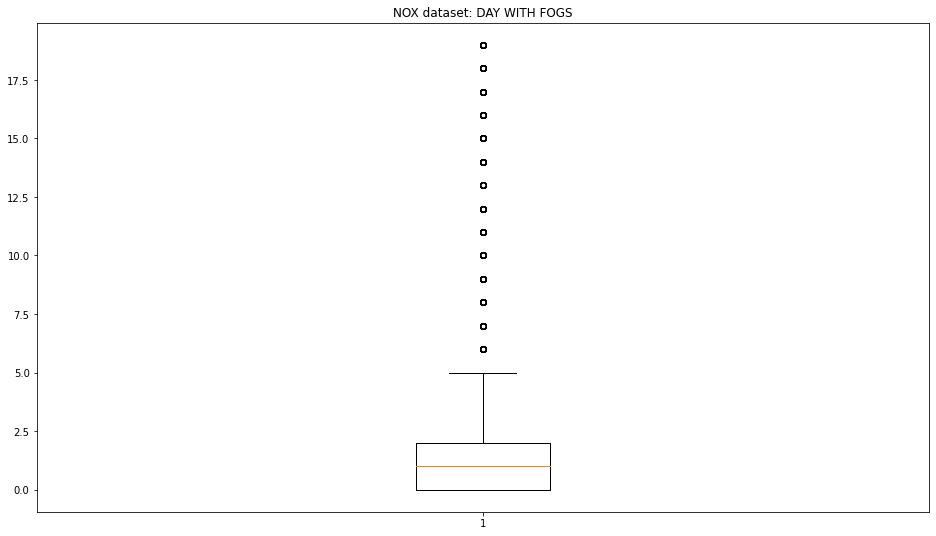

In [ ]:
_plot(NOX_dt, "NOX")

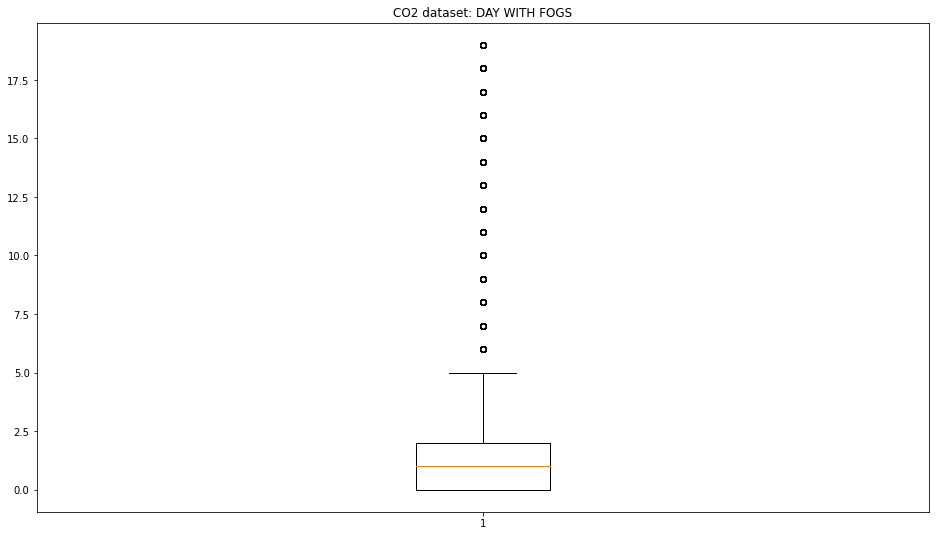

In [ ]:
_plot(CO2_dt, "CO2")

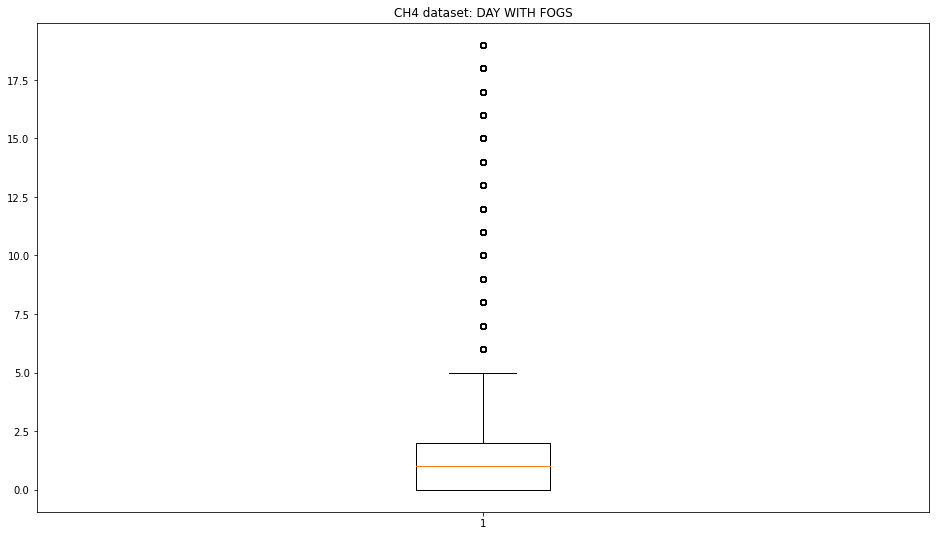

In [ ]:
_plot(CH4_dt, "CH4")

In [ ]:
def remove_out(data):
  """
  removes outliers over 5 IQR from the mean
  """
  data = data[(data["DAY WITH FOGS"] <= 5*iqr(data["DAY WITH FOGS"]))]
  return data

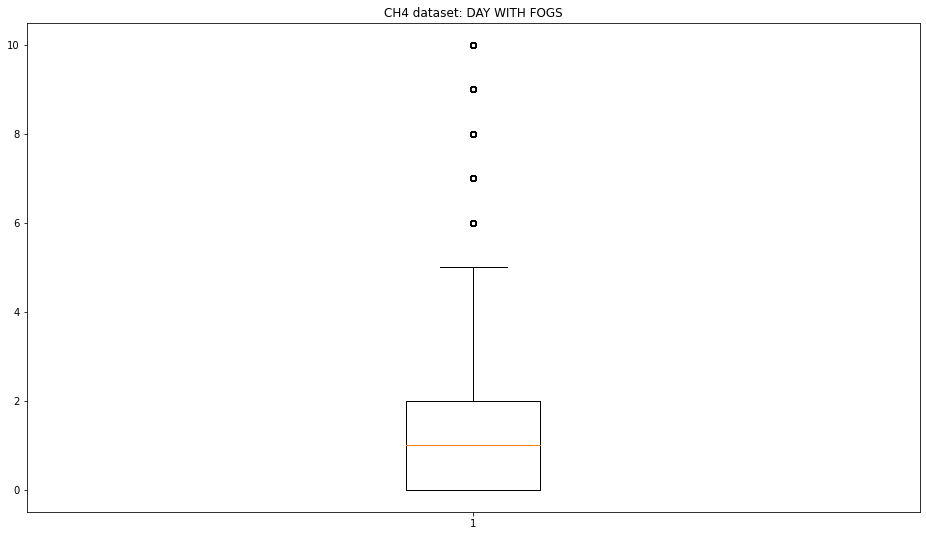

In [ ]:
NOX_dt_ = remove_out(NOX_dt)
CO2_dt_ = remove_out(CO2_dt)
CH4_dt_ = remove_out(CH4_dt)
_plot(CH4_dt_, "CH4")

In [ ]:
#Adding new column Target with value 0, 1, or 2
NOX_DT = NOX_dt_.copy(deep = True)
CO2_DT = CO2_dt_.copy(deep = True)
CH4_DT = CH4_dt_.copy(deep = True)
NOX_DT['Target'] = 0
CO2_DT["Target"] = 1
CH4_DT["Target"] = 2
# Appending datasets with the extra column
dt_ = NOX_DT.append(CO2_DT)[["City","EPRTRSectorCode", "DAY WITH FOGS", "EPRTRAnnexIMainActivityCode", "reportingYear", "MONTH", "countryName", "Target"]]
complete_dt = dt_.append(CH4_DT)[["City","EPRTRSectorCode", "DAY WITH FOGS", "EPRTRAnnexIMainActivityCode", "reportingYear", "MONTH", "countryName", "Target"]]
# Creating a new dataset
final_dataset = pd.DataFrame(complete_dt).reset_index(drop=True)

In [ ]:
def unique_encode(df, column_name):
  """
  gets unique values in dataframe column and returns a dictionary
  {value: encoded value}
  """
  return {value: encoded for encoded, value in enumerate(df[column_name].unique())}


def encode(self, *column_names):
  """
  method that encodes the values of columns using a dictionary
  """
  for column_name in column_names:
    encode_dict = unique_encode(self, column_name)
    self.replace({column_name: encode_dict}, inplace=True)

pd.DataFrame.encode = encode

In [ ]:
#city_dict = unique_encode(final_dataset, "City")
final_dataset.encode("City", "countryName", "EPRTRAnnexIMainActivityCode")

In [ ]:
#print(unique_encode(final_dataset, "City"))
final_dataset

,City,EPRTRSectorCode,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,reportingYear,MONTH,countryName,Target
0,0,3.0,2,0,2019,2,0,0
1,1,1.0,1,1,2018,5,1,0
2,2,1.0,0,1,2015,5,2,0
3,3,1.0,1,1,2011,8,3,0
4,4,1.0,2,1,2017,7,4,0
...,...,...,...,...,...,...,...,...
26669,4450,5.0,3,33,2019,10,13,2
26670,2356,5.0,3,33,2019,1,13,2
26671,4451,5.0,4,44,2019,1,13,2
26672,134,4.0,1,24,2019,11,13,2


In [ ]:
final_dataset.corr()

,City,EPRTRSectorCode,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,reportingYear,MONTH,countryName,Target
City,1.000000,0.393170,0.017152,0.491147,0.024402,-0.014477,0.011557,0.552911
EPRTRSectorCode,0.393170,1.000000,-0.028913,0.643602,0.040478,-0.001209,0.070121,0.344257
DAY WITH FOGS,0.017152,-0.028913,1.000000,-0.023520,0.001561,-0.005510,0.100492,0.059152
EPRTRAnnexIMainActivityCode,0.491147,0.643602,-0.023520,1.000000,0.026491,-0.005579,0.078626,0.516247
reportingYear,0.024402,0.040478,0.001561,0.026491,1.000000,0.013674,0.037928,0.021577
MONTH,-0.014477,-0.001209,-0.005510,-0.005579,0.013674,1.000000,0.001393,-0.010745
countryName,0.011557,0.070121,0.100492,0.078626,0.037928,0.001393,1.000000,0.056713
Target,0.552911,0.344257,0.059152,0.516247,0.021577,-0.010745,0.056713,1.000000


In [ ]:
final_dataset = final_dataset[["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode", "Target"]]

In [ ]:
test_data = test_data[["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode"]]

In [ ]:
X_train, X_test, y_train, y_test= train_test_split (final_dataset.iloc[:,:-1], final_dataset.iloc[:,-1], test_size=0.2, random_state=42) 

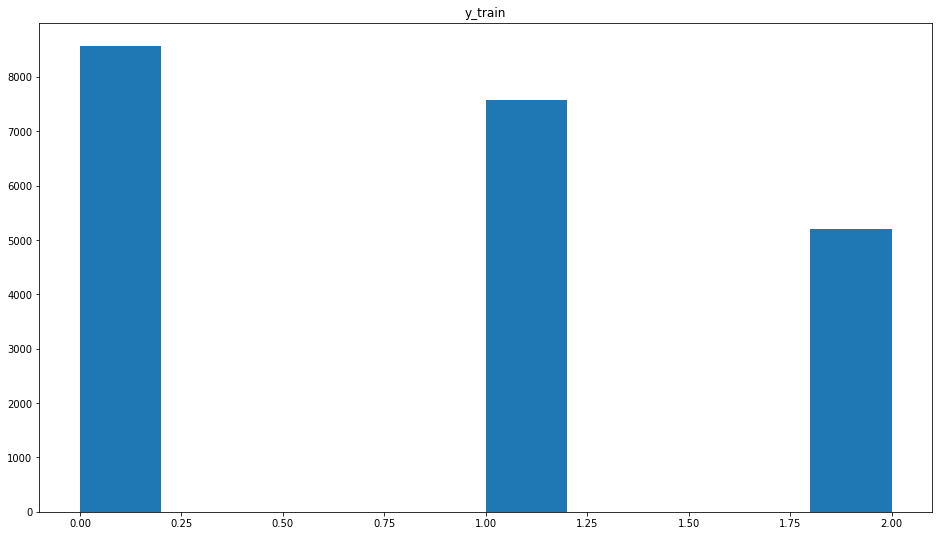

In [ ]:
# Histogram y_train 
plt.hist(y_train)
plt.title("y_train")
plt.show()

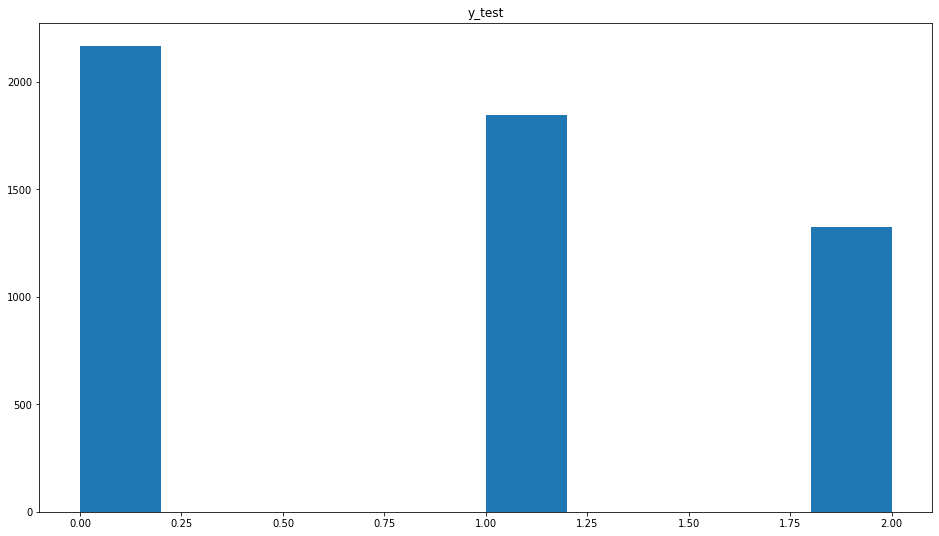

In [ ]:
# Histogram y_test 
plt.hist(y_test)
plt.title("y_test")
plt.show()

In [ ]:
scikit_models = {"SVC": SVC(),
                 "Decision tree": DecisionTreeClassifier(),
                 "Random forest": RandomForestClassifier(),
                 "Gradient boosting":GradientBoostingClassifier()}

scikit_models["Voting ensemble"] = VotingClassifier(estimators=[name_model_pair for name_model_pair in scikit_models.items()], voting='hard')

for name, model in scikit_models.items():
  model.fit(X_train, y_train)

  print(f"\033[94;1m{name} model statistics:{white}".center(53, "-"))

  print(f"\n\n{blue}RESULTS TEST DATASET{white}\n")

  # Prediction values based on testing dataset
  y_pred = model.predict(X_test)

  # Confusion matrix based on real classes and predictes ones
  model_confusion_matrix = confusion_matrix(y_test, y_pred)

  # Accuracy of model
  result = model.score(X_test, y_test)
                       
  # Report of model
  report = classification_report(y_test, y_pred)

  ### PRINT INFO
  print(f"{blue}Confusion matrix:{white}\n{matrix}\n")
  print(f"{blue}{name} Model Accuracy:{white} {result}\n")
  print(f"{report}\n")

  print(f"{blue}RESULTS TRAINING  DATASET{white}\n")

  # Prediction values based on training dataset
  y_pred_train = model.predict(X_train) 

  # Confusion matrix based on real classes and predictes ones
  matrix = confusion_matrix(y_train, y_pred_train)

  # Accuracy of model
  result = model.score(X_train, y_train) 

  # Report of model
  report = classification_report(y_train,y_pred_train)

  ### PRINT INFO
  print(f"{blue}Confusion matrix:{white}\n{matrix}\n")
  print(f"{blue}{name} Model Accuracy:{white} {result}\n")
  print(f"{report}\n")

-----------SVC model statistics:----------


RESULTS TEST DATASET

Confusion matrix:
[[7023 1392  153]
 [5016 2466   95]
 [ 440  188 4566]]

SVC Model Accuracy: 0.5998125585754451

              precision    recall  f1-score   support

           0       0.51      0.98      0.67      2166
           1       0.68      0.11      0.19      1846
           2       0.99      0.66      0.79      1323

    accuracy                           0.60      5335
   macro avg       0.73      0.58      0.55      5335
weighted avg       0.69      0.60      0.54      5335


RESULTS TRAINING  DATASET

Confusion matrix:
[[8326  242    0]
 [6721  805   51]
 [1594  187 3413]]

SVC Model Accuracy: 0.5878438539762876

              precision    recall  f1-score   support

           0       0.50      0.97      0.66      8568
           1       0.65      0.11      0.18      7577
           2       0.99      0.66      0.79      5194

    accuracy                           0.59     21339
   macro avg       0.71 

In [ ]:
NOX_dt_s = final_dataset[final_dataset["Target"]==0]
CO2_dt_s = final_dataset[final_dataset["Target"]==1]
CH4_dt_s = final_dataset[final_dataset["Target"]==2]

print("The length of NOX_dt_s is:", len(NOX_dt_s))
print("The length of CO2_dt_s is:", len(CO2_dt_s))
print("The length of CH4_dt_s is:", len(CH4_dt_s))

The length of NOX_dt_s is: 10734
The length of CO2_dt_s is: 9423
The length of CH4_dt_s is: 6517


In [ ]:
#undersampling
NOX_dt_s_sample=NOX_dt_s.sample(6517)
CO2_dt_s_sample=CO2_dt_s.sample(6517)
print("The new number of samples in noncustomer dataset is:", len(NOX_dt_s_sample))
print("The new number of samples in noncustomer dataset is:", len(CO2_dt_s_sample))

The new number of samples in noncustomer dataset is: 6517
The new number of samples in noncustomer dataset is: 6517


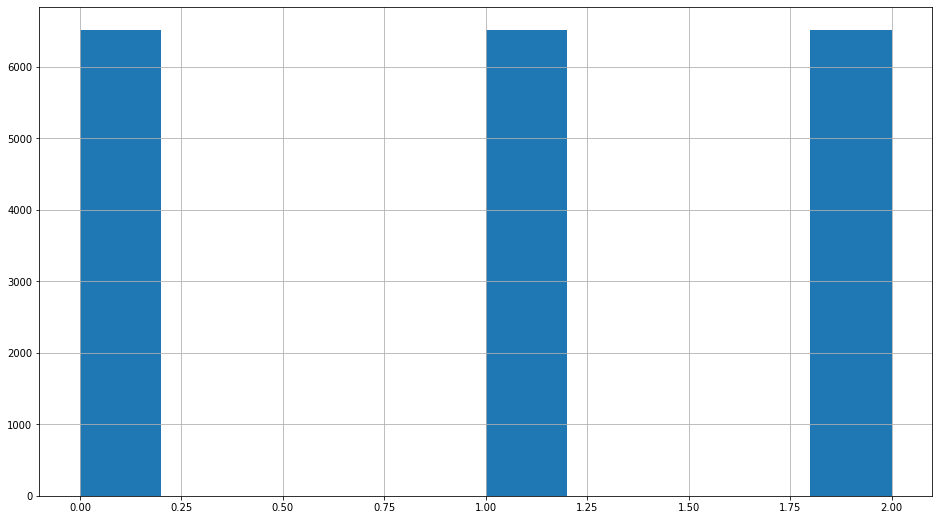

In [ ]:
dt_=NOX_dt_s_sample.append(CO2_dt_s_sample).reset_index().drop('index', axis=1)
final_dataset_= dt_.append(CH4_dt_s).reset_index().drop('index', axis=1)
final_dataset_=final_dataset_.loc[:,["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode", "Target"]]
final_dataset_.Target.hist()

In [ ]:
X_train, X_test, y_train, y_test= train_test_split (final_dataset_.iloc[:,:-1], final_dataset_.iloc[:,-1], test_size=0.2, random_state=42) 

In [ ]:
#TODO maybe not useless

# Classifiers
clf1 = DecisionTreeClassifier() 
clf2 = SVC()

# Ensambling Classifiers: Voting
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='hard')

# Train Model
eclf1.fit(X_train, y_train)

# Predictions
y_pred = eclf1.predict(X_test)

# Confusion Matrix, Accuracy, Report
matrix = confusion_matrix(y_test, y_pred)
result = eclf1.score(X_test, y_test)
report = classification_report(y_test, y_pred)

print("Confusion matrix:\n", matrix)
print("Accuracy:", result)
print(report)